#Ejemplo 10: Predicción de consumo de energía en casas
---



**Objetivo y comprensión del problema**

El objetivo de este ejemplo es predecir el consumo de energía en casas.

Para ello, se utilizará el siguiente conjunto de datos.


**Dataset:**

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


**Atributos:**

1. date: Date in format dd/mm/yyyy 
2. time: time in format hh:mm:ss 
3. global_active_power: household global minute-averaged active power (in kilowatt) 
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
5. voltage: minute-averaged voltage (in volt) 
6. global_intensity: household global minute-averaged current intensity (in ampere) 
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

##LSTMs

Referencia: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

* **Arquitectura general:** 

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)


* **Visión expandida**: 


![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)


* **Información a "olvidar"**: *The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at ht−1 and xt, and outputs a number between 0 and 1 for each number in the cell state Ct−1. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”*

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

* **Información a "guardar"**: *The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, C~t, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.*

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)


* **Información anterior a "borrar"**: *t’s now time to update the old cell state, Ct−1, into the new cell state Ct. The previous steps already decided what to do, we just need to actually do it. We multiply the old state by ft, forgetting the things we decided to forget earlier. Then we add it∗C~t. This is the new candidate values, scaled by how much we decided to update each state value.*

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

* **Información de salida**: *Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.*


![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

## Paso 1: Gestión de los datos




Para la configuración de las bibliotecas a importar, se incluye Keras, scikit-learn y pandas.

In [1]:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


**1.1-Carga de datos**

En este caso, los datos están disponibles como un CSV que se carga desde un directorio.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Cargar los datos en un dataset.

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')


**1.2-Visualización de los datos**

*   Se puede comprobar la forma que tienen nuestros datos. En este caso,  2075259 instancias con 7 dimensiones.


In [4]:
print(df.head(5))
print(df.columns.values)
print(df.info())
print(df.describe())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [0]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


* Chequeos de calidad de los datos.
* Borrado de los valores null.

In [0]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

* Los valores desconocidos se rellenan con la media de la columna.

In [0]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

* Se chequea que no hay valores nan.

In [0]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

* A continuación, se accede a la columna "Global_active_power" y se remuestrea a nivel de día ("D") calculando la suma y la media. Ambas tienen una forma similar.

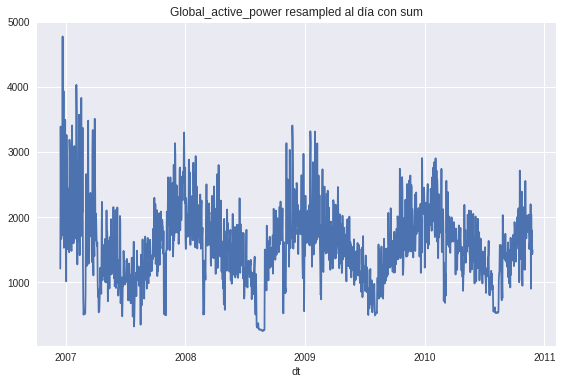

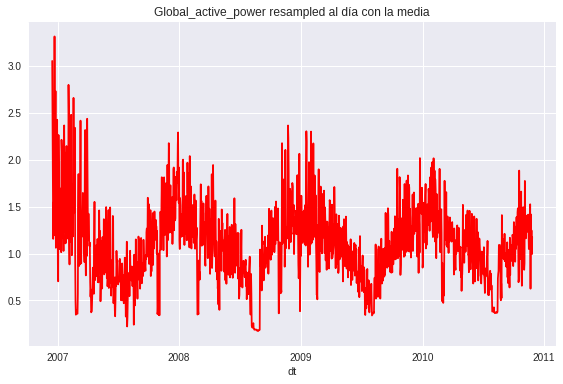

In [0]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled al día con sum') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled al día con la media', color='red') 
plt.tight_layout()
plt.show()

* A continuación, se accede a la columna "Global_intensity" y se remuestra a nivel de día ("D") calculando la suma y la media. Ambas tienen una forma similar.

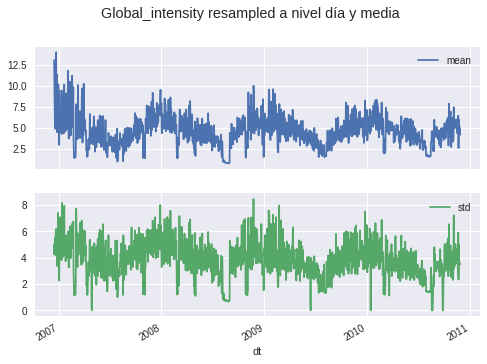

In [0]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled a nivel día y media')
plt.show()

* Se repite la acción con otra dimensión: "Global_reactive_power".

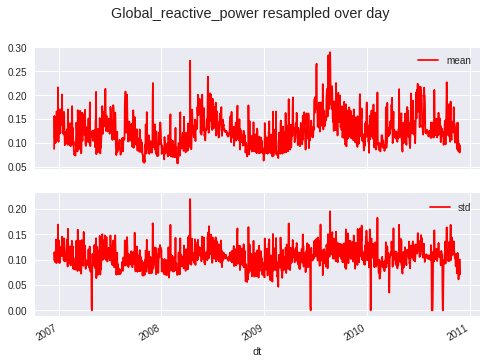

In [0]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

* Se repite la acción con otra dimensión: "Global_reactive_power" a nivel de mes ("M").

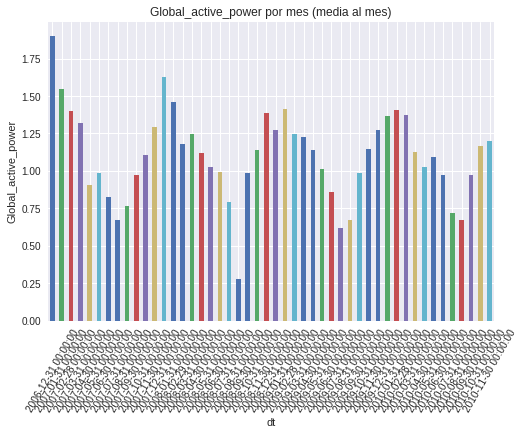

In [0]:
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power por mes (media al mes)')
plt.show()

* Se repite la acción con otra dimensión: "Global_reactive_power" y a nivel de trimestre (cuarto-"Q")

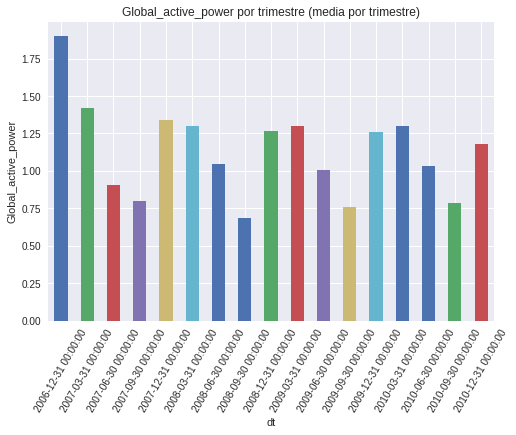

In [0]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power por trimestre (media por trimestre)')
plt.show()

* Es importante señalar que el muestreo en intervalos de tiempo largos disminuye la periodicidad de los datos implicando cierto impacto en la selección de características.

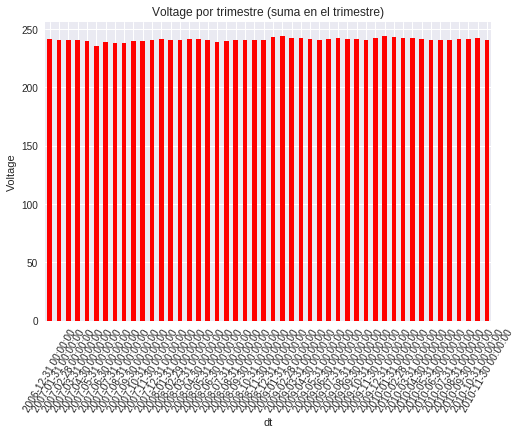

In [0]:
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage por trimestre (suma en el trimestre)')
plt.show()

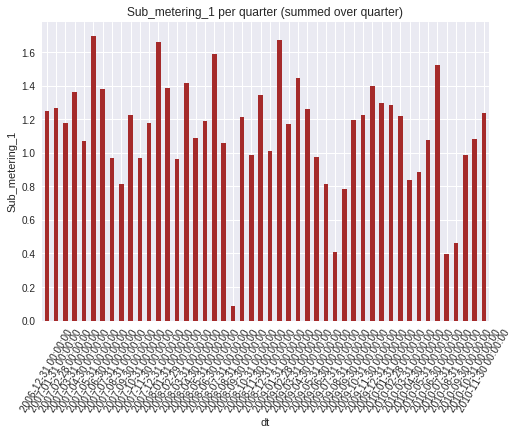

In [0]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 por mes (suma en el mes)')
plt.show()

* A continuación, se compara la media de las características muestreadas al día.

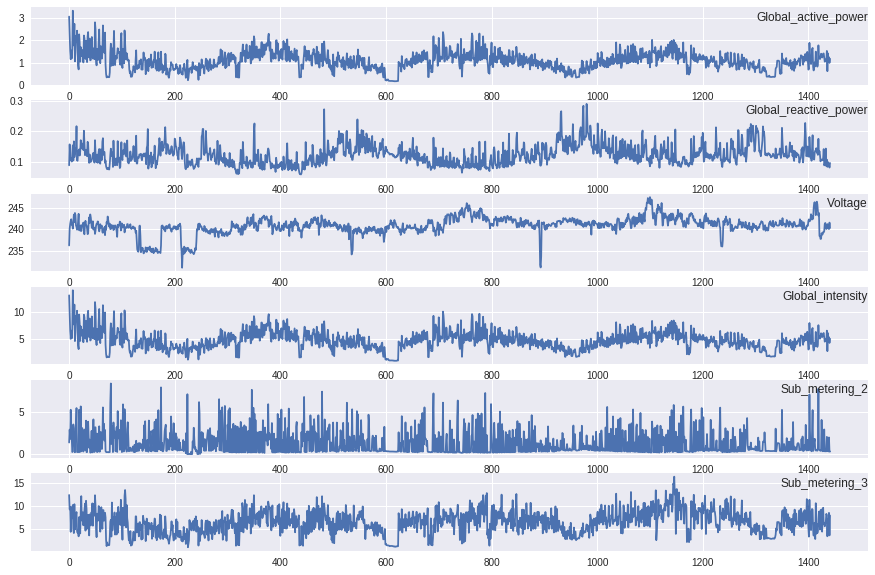

In [0]:
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot cada columna
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

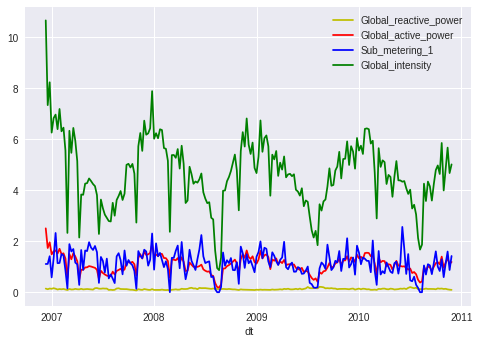

In [0]:
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

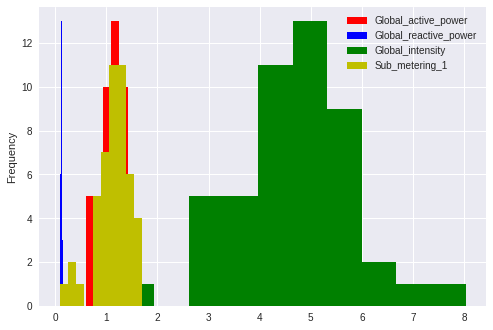

In [0]:
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

* A continuación, se muestra la correlación entre la intensidad ("Global intensity") y la energía ("Global active power").

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


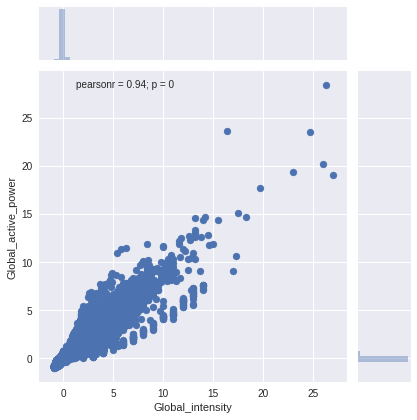

In [0]:
data_returns = df.pct_change()

#Percentage change between the current and a prior element.
#
#Computes the percentage change from the immediately previous row by default. This is useful in comparing the percentage of change in a time series of elements.

sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

* A continuación, se muestra la correlación entre el voltaje  ("Voltage") y la energía ("Global active power").

In [0]:
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

* A continuación, se muestra la correlación en las diferentes dimensiones.

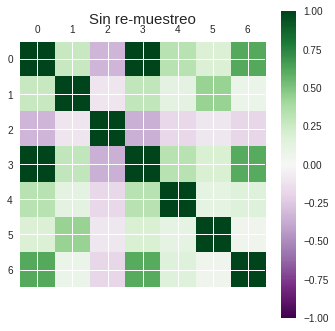

In [0]:
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Sin re-muestreo', size=15)
plt.colorbar()
plt.show()

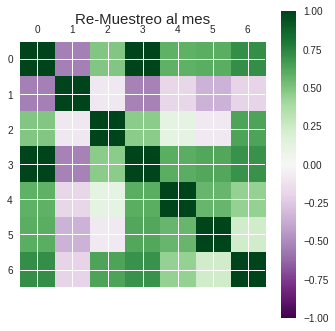

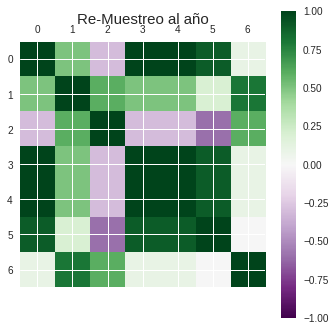

In [0]:
plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Re-Muestreo al mes', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Re-Muestreo al año', size=15)
plt.colorbar()
plt.show()

**1.3-Codificar los datos**

En este caso los datos son numéricos con lo que requieren procesamiento:

* Se preparan para predecir "Global_active_power" en el tiempo t, además de otras características.
* Se prepara los datos de acuerdo a esta ventana.



In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

* Se re-muestrean los datos a nivel de hora para reducir el número de observaciones (en minutos) de 2075259 a 34589.

In [6]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [7]:

values = df_resample.values 
## Se escalan los valores en el rango [0,1].
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Se convierten en un problema de aprendizaje supervisado
reframed = series_to_supervised(scaled, 1, 1)

# Se borran las columnas, dimensiones que no se quieren predecir
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


**1.4-Seleccionar los datos**

En este caso, los datos ya están preparados y divididos apropiadamente.





In [8]:
# Se separan los valores de entrenamiento y test
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# Se separan las entradas y salidas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Se da una nueva forma en 3D [samples, timesteps, features]
# Así es como lo espera una LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 7) (8760,) (25399, 1, 7) (25399,)


## Paso 2: Arquitectura e implementación de nuestra red


1.   La salida de nuestra red será una capa con 100 nodos siendo la entrada la forma de nuestro dataset.
2.   Se utiliza una función de Dropout para evitar el overfitting.
3.   La función de activación en la capa de salida no se utiliza para producir un valor escalar. 
4. La función de pérdida será  **mse**.
5. La función de optimización **adam**. 
6. Métricas: en este caso se selecciona sólo la precisión.



In [16]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(100))
#model.add(Dropout(0.2))
model.add(Dense(1))




ValueError: ignored

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

## Paso 3:  Entrenamiento



En este caso el entrenamiento se realiza de la siguiente forma:

* Epochs: 20 (nº de pasadas completas del conjunto de datos).
* Batch size: 70 (submuestra de datos)

In [11]:
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    

Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 25399 samples
Epoch 1/20
 - 2s - loss: 0.0193 - val_loss: 0.0118
Epoch 2/20
 - 1s - loss: 0.0125 - val_loss: 0.0103
Epoch 3/20
 - 1s - loss: 0.0115 - val_loss: 0.0097
Epoch 4/20
 - 1s - loss: 0.0109 - val_loss: 0.0093
Epoch 5/20
 - 1s - loss: 0.0108 - val_loss: 0.0093
Epoch 6/20
 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 7/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 8/20
 - 1s - loss: 0.0107 - val_loss: 0.0092
Epoch 9/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 10/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 11/20
 - 1s - loss: 0.0106 - val_loss: 0.0091
Epoch 12/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 13/20
 - 1s - loss: 0.0105 - val_loss: 0.0091
Epoch 14/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 16/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 17/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 18/20
 - 1s - loss: 0.

* Se muestra, a acontinuación, la pérdida.

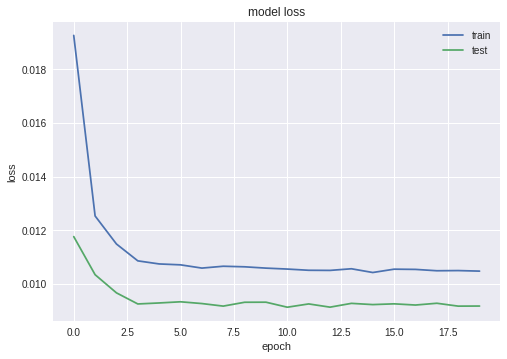

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Paso 4:  Test y Predicción

En este caso, se va a validar con el conjunto de test y predicción:


*   Se intenta predecir con el conjunto de prueba (text_X).
*   Se calcula RMSE.
*   Se obtiene el valor de la predicción como una probabilidad.
*   Se muestra la matriz de confusión y se calcula "a mano" la precisión de esta validación.



In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.617


* Se muestra la pérdida por cada una de las iteraciones.

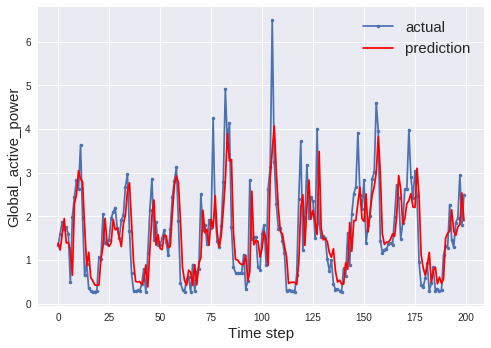

In [14]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

#Paso 6: Guardar configuración del modelo

In [0]:
network.save('/content/drive/My Drive/Colab Notebooks/models/ejemplo-10.h5')

#Tareas

1.   Cambiar el tipo de la función de pérdida y ver cómo afecta al resultado.
2.   Cambiar la función de optimización y ver cómo afecta al resultado.
3.   Cambiar la toplogía de la red.

**Notas**:

* Se utiliza una LSTM porque se tienen muchos datos y son secuenciales.
* Sólo se toma un año como entrenamiento y el resto de prueba.
* El tiempo de computación es alto, quizá se debería pensar en distribuir (MLIB).
* La arquitectura es sencilla se puede mejorar introduciendo más capas como CNN ya que hay correlación en los datos 

#Otras referencias

* https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial